# 集成训练跟踪的快速训练示例

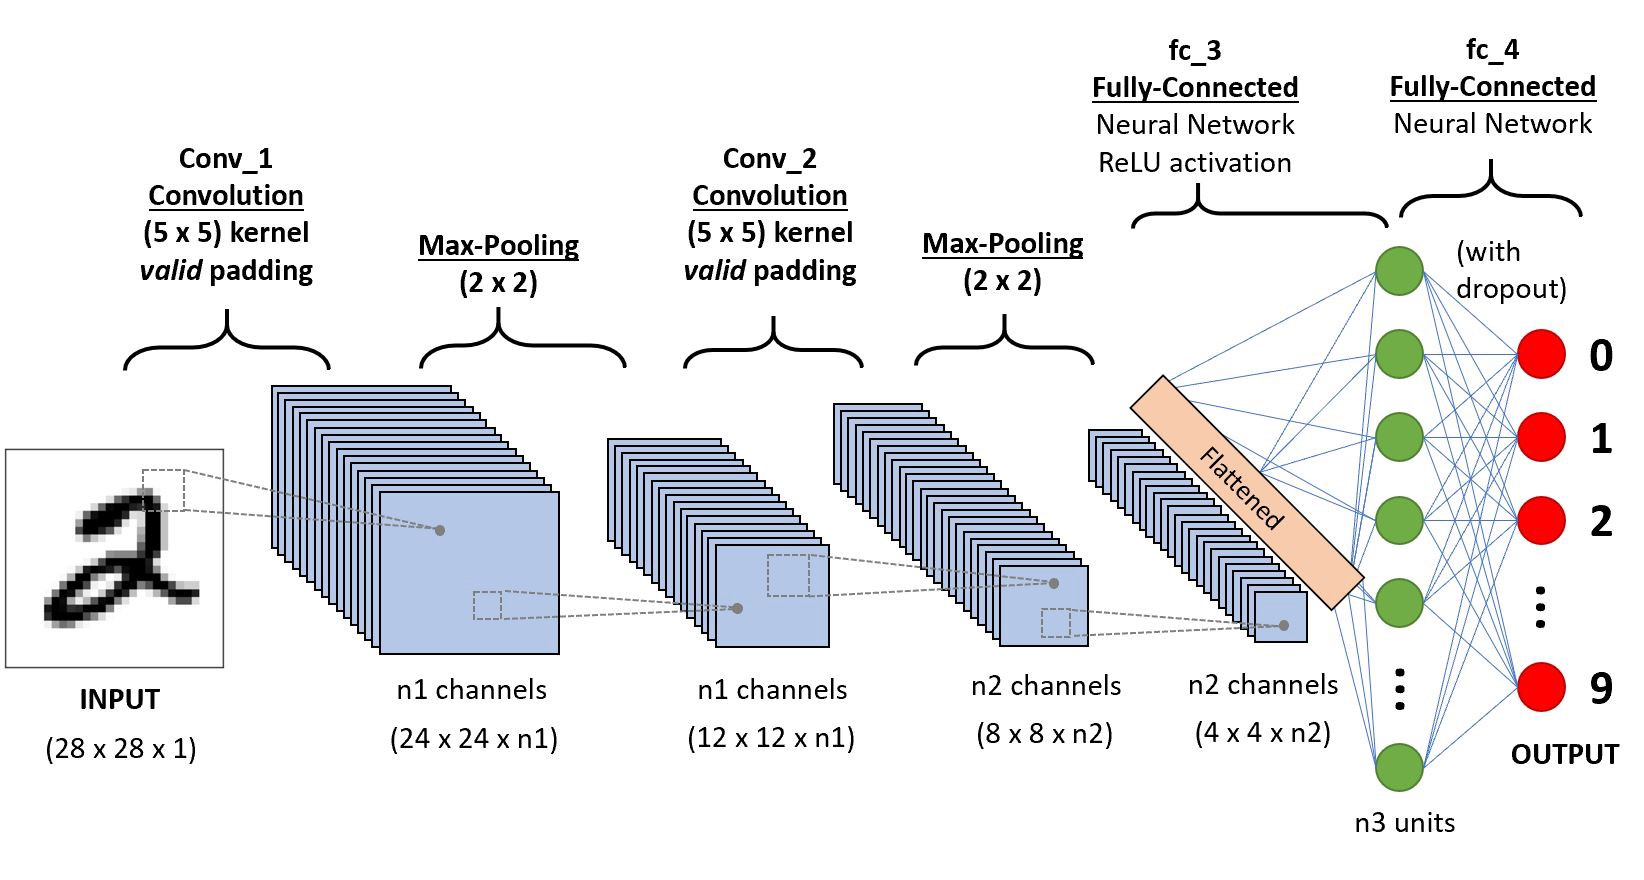

In [4]:
from IPython.display import Image
Image(filename='../../resources/img/cnn.jpeg', width=640)

### 一个简单的CNN

In [2]:
# 主体逻辑，忽略部分细节
def demo_cnn():
    class EpochEndCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs=None):
            acc = logs['val_acc'] if 'val_acc' in logs else logs['val_accuracy']
            print(f"Current acc: {acc}")

    parser = argparse.ArgumentParser()
    (X_train, y_train), (X_test, y_test) = load_data_local(path=args.data_path)
    # ......

    # Build model
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, [3, 3], activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        # ......
    ])
    opt = tf.keras.optimizers.Adam(_learning_rate)
    model.compile(optimizer=opt,
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=['accuracy'])
    # ......

    # Train
    model.fit(dset_train,
              callbacks=callbacks,
              epochs=_epochs)
    # Test
    test_loss, test_acc = model.evaluate(dset_test, verbose=2)
    # Save
    model.save(_model_dir)

### 轻量修改代码，植入SDK的跟踪接口

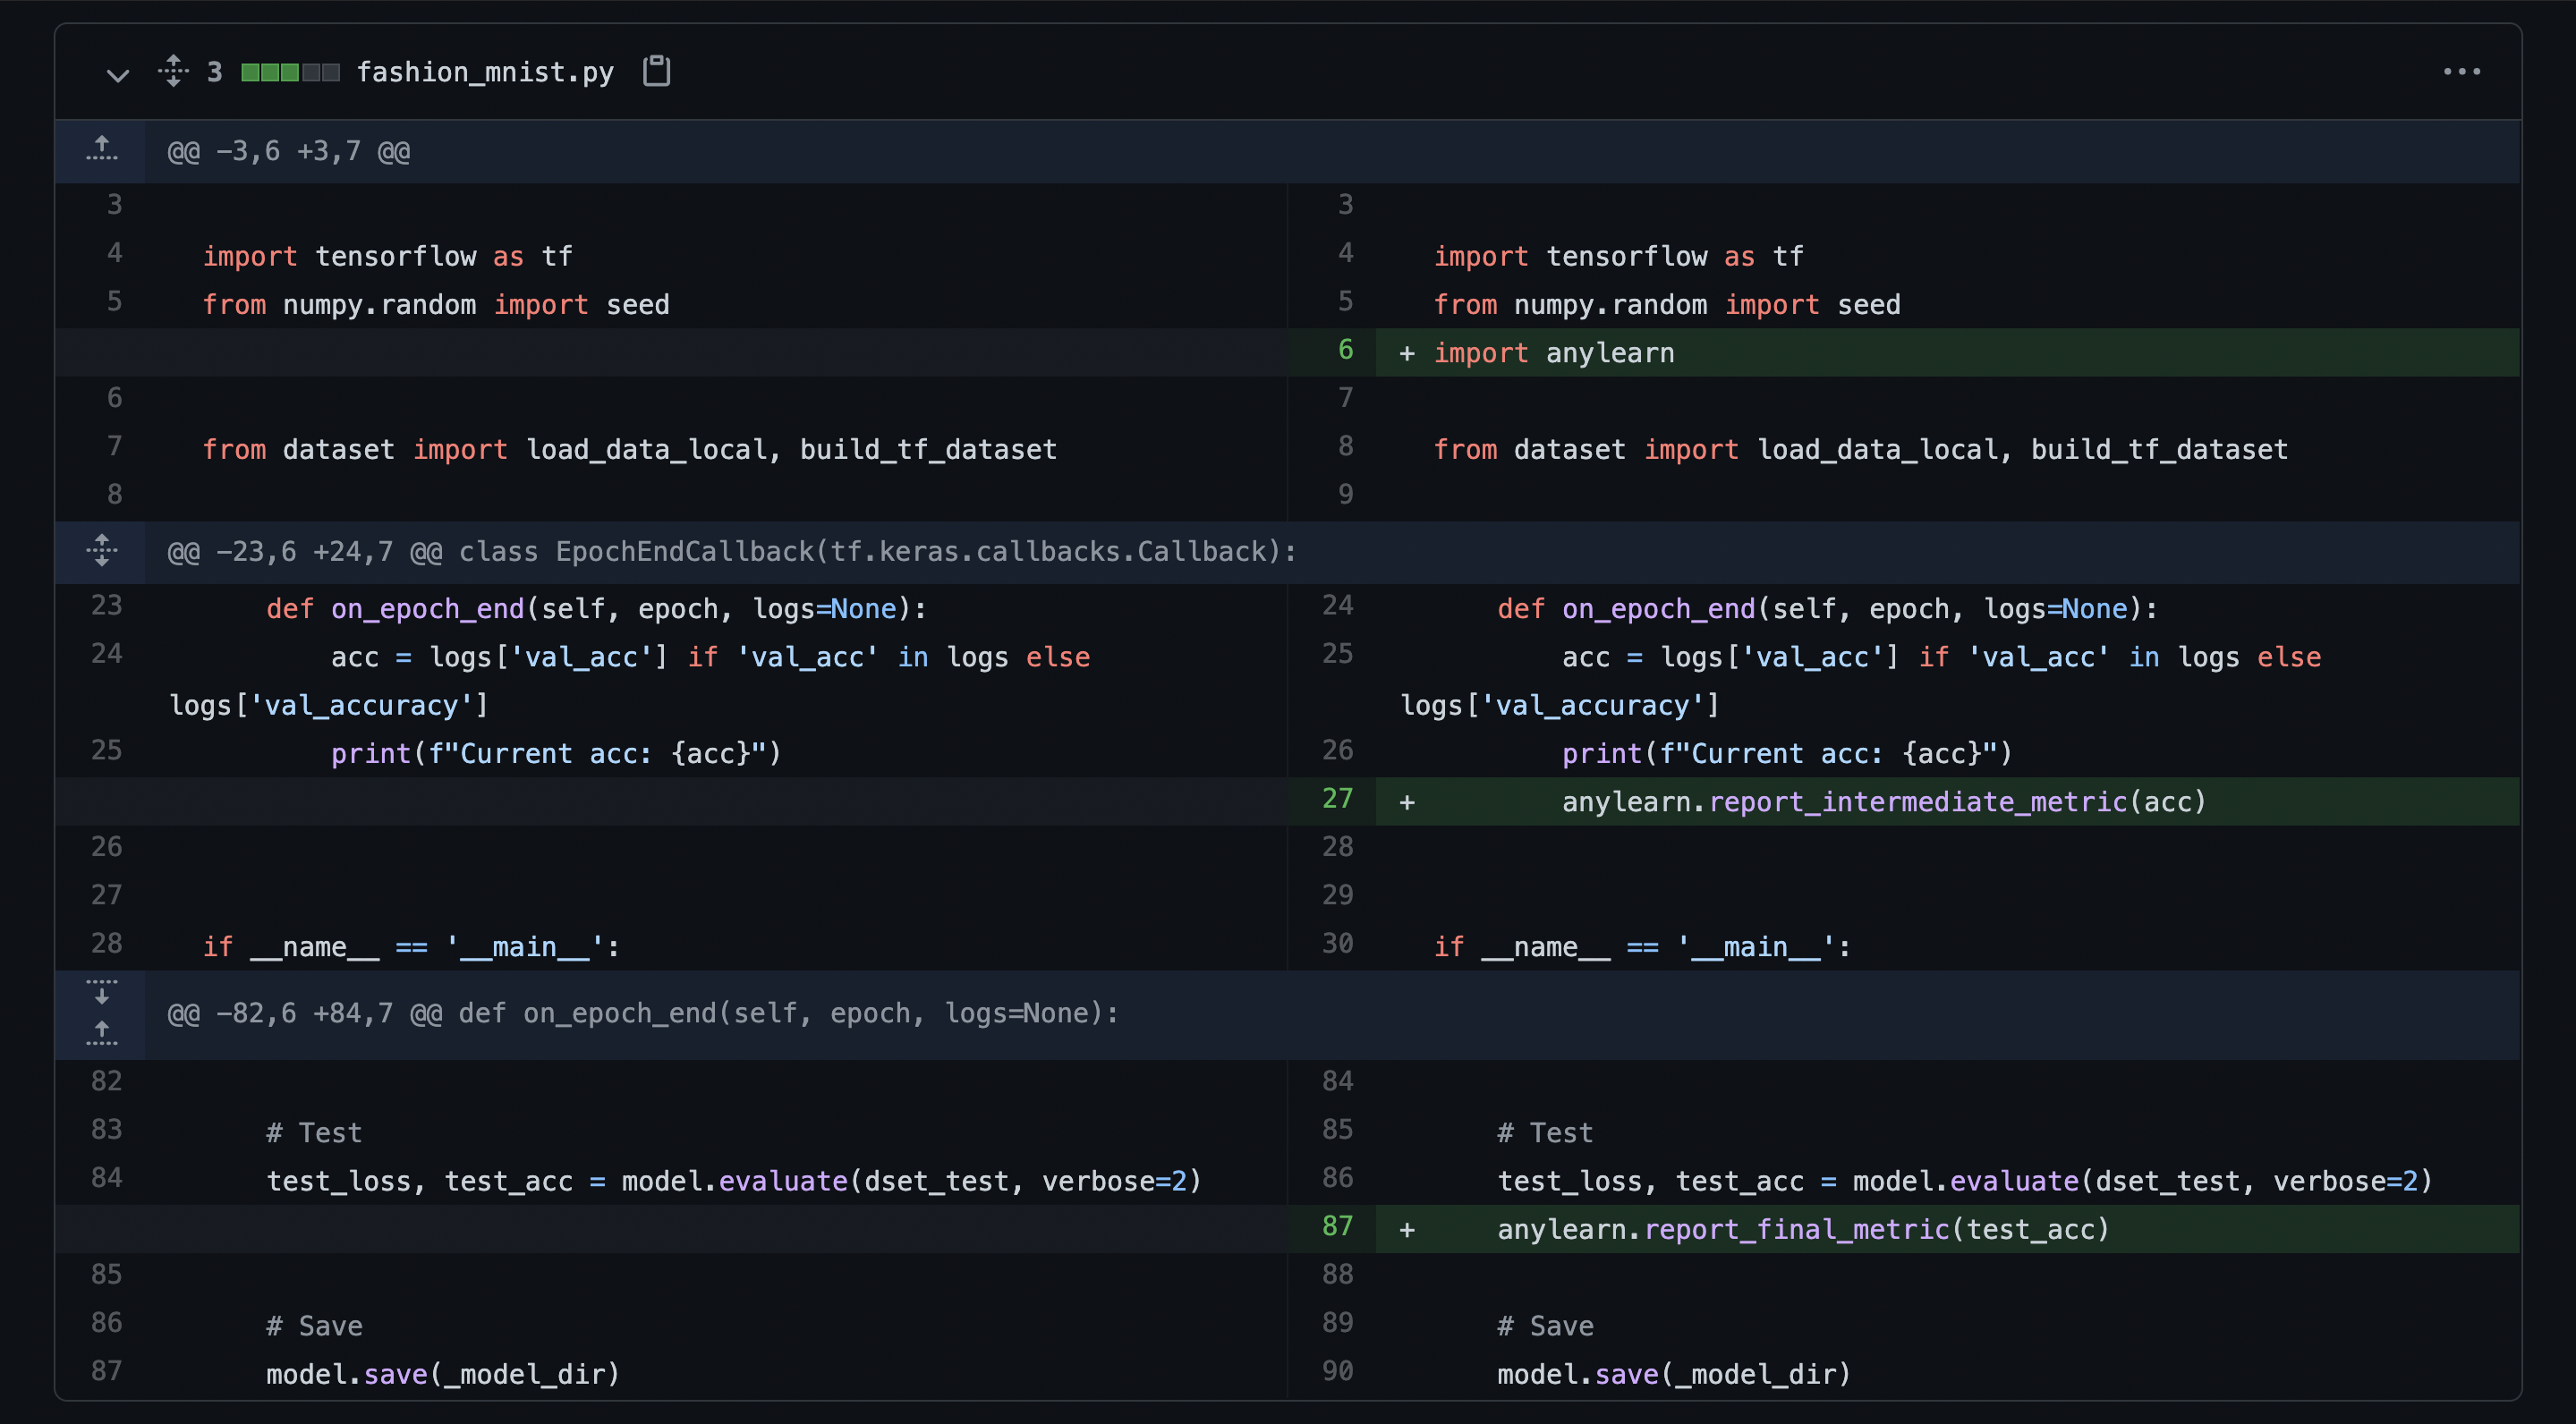

In [5]:
from IPython.display import Image
Image(filename='../../resources/img/diff-tracking.png', width=1024)

### 初始化SDK与Anylearn后端引擎连接

In [1]:
from anylearn.config import init_sdk
init_sdk('http://anylearn.xyz', 'username', 'password')

### 获取资源组

#### /!\ 版本0.11.0起，创建训练时，需要额外增加计算资源请求
这里需取到用户想要访问的资源组的ID，后续创建训练时会用到

In [3]:
from anylearn.interfaces import QuotaGroup
groups = QuotaGroup.get_list()
groups

[QuotaGroup(id='QGRP03fe160211ecb6119ef94103bf12', name='METEO', level='Guarantee', node_level='meteo', capacity={'A-100-unique': 4, 'CPU': 32, 'Memory': 128}, default={'A-100-unique': 1, 'CPU': 8, 'Memory': 32}, allocated={'A-100-unique': 1, 'CPU': -3, 'Memory': -4})]

### 创建快速训练任务

#### /!\ 版本0.11.0起，创建训练时，需要额外增加计算资源请求
上一步获取到的资源组的ID在这里会用到

In [7]:
import logging
logging.basicConfig(level=logging.INFO)

from anylearn.applications.quickstart import quick_train
from anylearn.interfaces.resource import SyncResourceUploader
train_task, algo, dset, project = quick_train(
    algorithm_name="YHU_CLI_CNN",
    algorithm_dir="../../resources/cnn",
    dataset_dir="../../resources/fashion_mnist",
    entrypoint="python fashion_mnist.py",
    output="model",
    mirror_name="QUICKSTART",
    dataset_hyperparam_name="data-path",
    hyperparams={'batch-size': 128, 'epochs': 2},
    resource_request=[{
        'QGRP03fe160211ecb6119ef94103bf12': {
            'A-100-unique': 1,
            'CPU': 4,
            'Memory': 4,
        }
    }],
    resource_uploader=SyncResourceUploader(),
)
train_task

INFO:anylearn_sdk_applications:Packaging resources...
INFO:anylearn_sdk_algorithm_manager:Uploading algorithm YHU_CLI_CNN...
INFO:anylearn_sdk_resource_uploader:Uploaded 100%
INFO:anylearn_sdk_algorithm_manager:Successfully uploaded algorithm
INFO:anylearn_sdk_applications:Packaging resources...


TrainTask(name='vohedbux', description='', state=0, visibility=1, creator_id='USERee16e08a11ebbbe9d2ff387e91ee', owner=[], project_id='PROJ4d851bcc4c6586c4caf1f7b060b4', algorithm_id='ALGO324c15f411ec81fa7225378e3d03', train_params='{"data-path": "$DSETe4141c4111ecb9aa424b453a05e6", "batch-size": 128, "epochs": 2}', files='DSETe4141c4111ecb9aa424b453a05e6', results_id='FILEaaa81c4311ec8e884a6bbbd340b7', secret_key='TKEY497a1c4311ec8e884a6bbbd340b7', create_time='2021-09-23 15:51:32', finish_time='', envs='', gpu_num=0, gpu_mem=0, hpo=False, hpo_search_space=None, final_metric=None, resource_request=[{'QGRP03fe160211ecb6119ef94103bf12': {'A-100-unique': 1, 'CPU': 4, 'Memory': 4}}], id='TRAIb7761c4311ec8e884a6bbbd340b7')

### 追踪训练中间结果和最终结果

In [6]:
import time

status = train_task.get_status()
while 'state' not in status:
    print("Waiting...")
    time.sleep(30)
    status = train_task.get_status()
while status['state'] not in ["success", "fail"]:
    if 'process' in status:
        print(f"Progress: {int(100 * float(status['process']))}%")
    else:
        print(status['state'])
    try:
        print(f"-- last metric: {train_task.get_intermediate_metric()[-1]['metric']}")
    except:
        print(f"-- no metric yet")
    time.sleep(30)
    status = train_task.get_status()
    print(status)
print(f"Final metric: {train_task.get_final_metric()['final_metric']}")
status['state']

Final metric: 0.9279999732971191


'success'